# GOES and IBTrACS Data with Projections

Now that we've explored the GOES satellite data and the IBTrACS data in Python, let's put them both together. In order to do so, we'll have to obtain the projection data of the GOES imagery, project the IBTrACS latitudes/longitudes using the GOES projection data, and then overlay the track on the GOES imagery.

We focus specifically on the track of [Hurricane Harvey in 2017](https://en.wikipedia.org/wiki/Hurricane_Harvey). This was a devastating storm that first made landfall in Texas. I chose this storm because I'm pretty familiar with it and know what to expect for the imagery and the track.

## Import Modules

Let's first import the modules we need to run the code. I've written some functions for getting the IBTrACS and GOES data, so let's import those functions now too.

In [1]:
# Import modules
import datetime
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import functions I've written
import sys
sys.path.append("../scripts")
import goes
import ibtracs

## Retrieve IBTrACS Data

Now let's load up the IBTrACS data, as we did in a previous notebook, and then drill down on the track for Hurricane Harvey in 2017.

In [2]:
# Set the file path for the IBTrACS data
file_path = ibtracs.download_data(basin="NA",data_dir='../data/ibtracs',overwrite=False)

# Read the data from the CSV
df = ibtracs.read_data(file_path)

# Keep only the Hurricane Harvey (2017) track
df = df[df['SEASON'] == 2017]
df = df[df['NAME'] == 'HARVEY']

# Show a preview
df.head()

,SID,SEASON,NUMBER,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,STORM_SPEED,STORM_DIR
117520,2017228N14314,2017,60,HARVEY,2017-08-16 06:00:00,DS,13.7,-45.8,25,1013,main,1209,1157,O______________,16,270
117521,2017228N14314,2017,60,HARVEY,2017-08-16 09:00:00,DS,13.7,-46.6,,,main,1157,1109,P______________,16,270
117522,2017228N14314,2017,60,HARVEY,2017-08-16 12:00:00,DS,13.7,-47.4,25,1010,main,1109,1067,O______________,16,270
117523,2017228N14314,2017,60,HARVEY,2017-08-16 15:00:00,DS,13.6,-48.2,,,main,1057,1018,P______________,16,265
117524,2017228N14314,2017,60,HARVEY,2017-08-16 18:00:00,DS,13.6,-49.0,25,1009,main,1018,986,O______________,16,270


## Retrieve GOES16 Image

Now let's grab a GOES16 image corresponding to Hurricane Harvey. It made landfall in Texas around August 25, 2017, so we'll set the date for the image to be that day.

In [3]:
# Get the GOES data
ds = goes.get_goes_file(position='goes-east', date=datetime.datetime(2017,8,25), hour=18, band=3, product='ABI-L1b-RadF')
display(ds)

Using goes16 for goes-east on 2017-08-25
Found file: OR_ABI-L1b-RadF-M3C03_G16_s20172371800364_e20172371811131_c20172371811172.nc


<xarray.Dataset> Size: 942MB
Dimensions:                                 (y: 10848, x: 10848,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             num_star_looks: 24, band: 1)
Coordinates:
  * y                                       (y) float32 43kB 0.1519 ... -0.1519
  * x                                       (x) float32 43kB -0.1519 ... 0.1519
    t                                       datetime64[ns] 8B 2017-08-25T18:0...
    y_image                                 float32 4B 0.0
    x_image                                 float32 4B 0.0
    band_id                                 (band) int8 1B 3
    band_wavelength                         (band) float32 4B 0.865
    t_star_look                             (num_star_looks) datetime64[ns] 192B ...
    band_wavelength_star_look               (num_star_looks) float32 96B -999...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                num_star_looks, band
Data variables: (12/31)
    Rad                                     (y, x) float32 471MB nan nan ... nan
    DQF                                     (y, x) float32 471MB nan nan ... nan
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                  int32 4B -2147483647
    y_image_bounds                          (number_of_image_bounds) float32 8B ...
    x_image_bounds                          (number_of_image_bounds) float32 8B ...
    ...                                      ...
    percent_uncorrectable_L0_errors         float32 4B 0.0
    earth_sun_distance_anomaly_in_AU        float32 4B 1.011
    algorithm_dynamic_input_data_container  int32 4B -2147483647
    processing_parm_version_container       int32 4B -2147483647
    algorithm_product_version_container     int32 4B -2147483647
    star_id                                 (num_star_looks) float32 96B nan ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 3
    date_created:              2017-08-25T18:11:17.2Z
    time_coverage_start:       2017-08-25T18:00:36.4Z
    time_coverage_end:         2017-08-25T18:11:13.1Z
    id:                        9d908e88-46bc-42d2-8678-2377766ac0c7

Next, let's plot the GOES full disk image

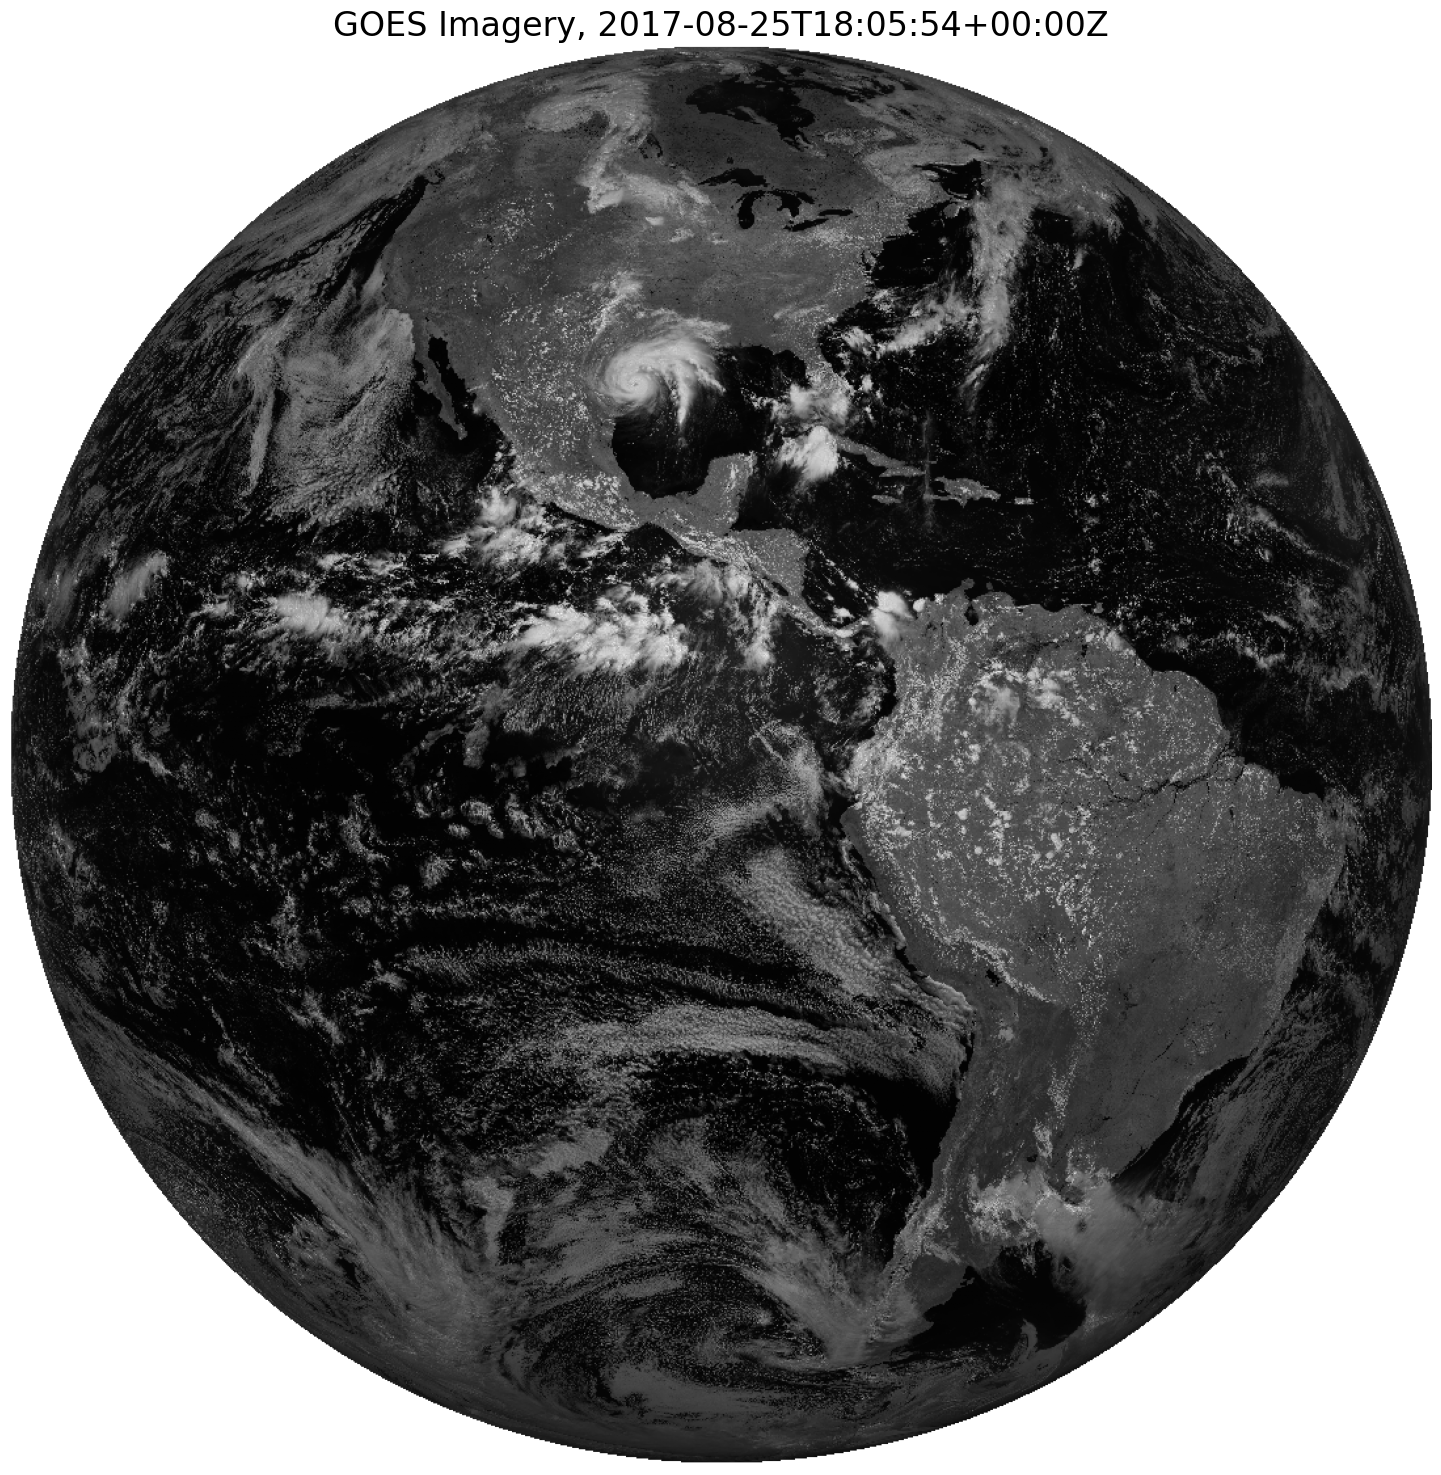

In [4]:
# Convert to timestamp (seconds since epoch) then to datetime
timestamp = ds['t'].values.astype('datetime64[s]').astype(int)
date = datetime.datetime.fromtimestamp(timestamp, datetime.UTC)

# Downsample by a factor (e.g., every 10th pixel)
downsample_factor = 10
rad_small = ds.Rad[::downsample_factor, ::downsample_factor]

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Fill plot data
ax.imshow(rad_small, cmap='gray')

# Add titles
fig.suptitle(f"GOES Imagery, {date.isoformat()}Z", fontsize=24)

# Turn off axes
ax.axis('off')
plt.tight_layout()

## Overlay IBTRaCS Data and State and Country Boundaries

To make sure we've got the projection right, we start by overlaying the boundaries of states, countries, and coastlines on the GOES imagery. In order to do so, we need to get the projection of the GOES data. This information is stored in the netCDF metadata, primarily as attributes for the variable `goes_imager_projection`. So once we get the projection data, we'll load this into the base map, and then the borders should be easily drawn using the base map utilities.

With the projection is working properly, we can add the Hurricane Harvey track as of August 25, 2017 at 18Z. We first need to grab the latitude longitudes from the IBTRaCS data. We can then use the projection to convert longitudes and latitudes to the $x$ and $y$ space of the projected GOES image.

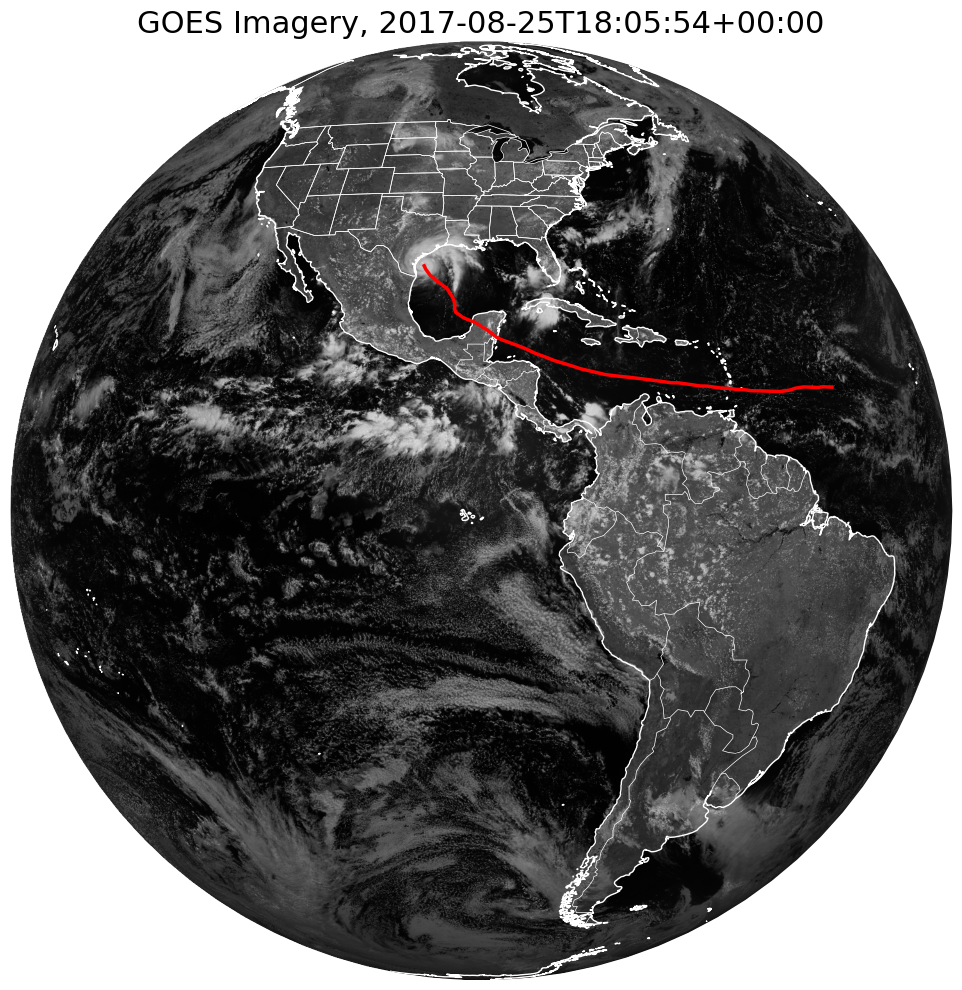

In [5]:
# Get dataset projection data
satHeight = ds.goes_imager_projection.perspective_point_height
satLon = ds.goes_imager_projection.longitude_of_projection_origin
satSweep = ds.goes_imager_projection.sweep_angle_axis
semi_major = ds.goes_imager_projection.semi_major_axis
semi_minor = ds.goes_imager_projection.semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
x = ds.variables['x'][:] * satHeight
y = ds.variables['y'][:] * satHeight

# Downsample the radiance data
downsample_factor = 8
rad_display = ds.Rad[::downsample_factor, ::downsample_factor]

# Downsample the x and y coordinates accordingly
x_display = x[::downsample_factor]
y_display = y[::downsample_factor]

# Create the geostationary projection for Cartopy
globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
proj = ccrs.Geostationary(
    central_longitude=satLon,
    satellite_height=satHeight,
    globe=globe,
    sweep_axis=satSweep
)

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

# Plot the downsampled GOES imagery
ax.imshow(
    rad_display, 
    origin='upper',
    extent=[x.min(), x.max(), y.min(), y.max()],  # Use original extent
    transform=proj,
    cmap='gray',
    interpolation='bilinear'  # Smooth the downsampled image
)

# Add map features
ax.coastlines(resolution='50m', color='white', linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='white')

# Get the latitudes/longitudes of the track data
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
date_ts = pd.Timestamp(date).tz_localize(None) if hasattr(pd.Timestamp(date), 'tz') else pd.Timestamp(date)
df_track = df[df['ISO_TIME'] <= date_ts]
latList = list(df_track['LAT'])
lonList = list(df_track['LON'])

# Plot the track (transform from lat/lon to the geostationary projection)
ax.plot(
    lonList, 
    latList, 
    linewidth=2.5, 
    color='r',
    transform=ccrs.PlateCarree()  # Input coordinates are in lat/lon
)

plt.axis('off')
plt.title(f'GOES Imagery, {date.isoformat()}', fontsize=22)
plt.tight_layout()
plt.show()